# Generate DEA Hotspots animations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)


## Description
This notebook loads DEA Hotspots data for a given time and location, and animates the data over a 2018 Geomedian underlay with fading colours that represent the age of the hotspot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [27]:
import os
import datacube
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# # Create custom cmap with dark grey at end 
fires_cmap = get_cmap('YlOrRd')
fires_cmap.set_over('#111211')

dc = datacube.Datacube(app="DEA_hotspots")

act_boundary = 'https://data.gov.au/geoserver/act-state-boundary-psma-administrative-boundaries/wfs?request=GetFeature&typeName=ckan_83468f0c_313d_4354_9592_289554eb2dc9&outputFormat=json'


## Parameters

Set parameters used to load and visualise DEA Hotspots data

In [17]:
# Setup params
name = 'actfire'  # name used for output files
time_period = 7  # days from current date to include in animation (e.g. a month or week of data)
y_max, x_min = -35.40, 148.70  # top left coordinates of bbox
y_min, x_max = -36.00, 149.30  # bottom right coordinates of bbox
min_confidence = 0  # minimum confidence value of hotspots to include in animation
max_features = 900000  # maximum features to load from WFS
avhrr=False

# Visualisation params
frame_freq = '80T'  # frequency used to generate animation frames (e.g. one frame every 3 hours). Smaller numbers create longer, smoother animations but take longer to render
hotspots_markersize = 16  # size to plot hotspots on map
hotspots_alpha = 0.9  # transperancy to plot hotspots on map
fade_hours = 24  # hours used to fade hotspots from yellow to black
geomedian_res = 0.0006  # resolution in degrees to load geomedian underlay (smaller = slower rendering)

## Load and clean hotspots data

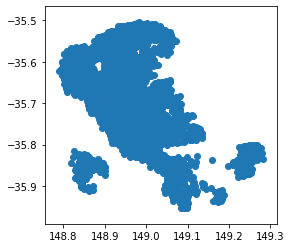

In [20]:
# Load WFS query data
to_date = (dt.datetime.today() + dt.timedelta(days=1)).strftime('%Y-%m-%d')
from_date = (dt.datetime.today() - dt.timedelta(days=time_period)).strftime('%Y-%m-%d')
avhrr_string = '(sensor=%27AVHRR%27%20AND%20(product=%27SRSS%27))%20OR%20' if avhrr else ''
url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({avhrr_string}(sensor=%27MODIS%27%20AND%20(product=%27MOD14%27))%20OR%20(sensor=%27VIIRS%27%20AND%20(product=%27AFMOD%27%20OR%20product=%27EDR%27)))%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_min}%20{x_min},%20{y_min}%20{x_max},%20{y_max}%20{x_max},%20{y_max}%20{x_min},%20{y_min}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
hotspots_gdf = gpd.read_file(url)

# Filter by confidence
hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

# Fix datetime
hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

# Extract required columns
hotspots_gdf = hotspots_gdf.loc[:, [
    'datetime', 'latitude', 'longitude', 'temp_kelvin', 'confidence', 'geometry'
]]
hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
hotspots_gdf.plot()

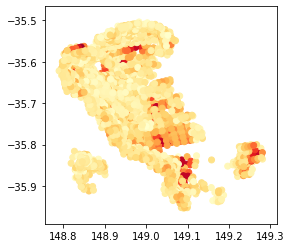

In [21]:
hotspots_gdf.plot(column='temp_kelvin', cmap=fires_cmap)

## Load 2018 geomedian underlay

In [6]:
# Create a query object
query = {
    "time": '2018',
    "x": (x_min, x_max),
    "y": (y_max, y_min),
    "measurements": ["red", "green", "blue"],
    "output_crs": "EPSG:4326",
    "resolution": (-geomedian_res, geomedian_res),
}

ds = dc.load(product="ls8_nbart_geomedian_annual", **query)
ds

<xarray.Dataset>
Dimensions:    (latitude: 1000, longitude: 1001, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01
  * latitude   (latitude) float64 -35.4 -35.4 -35.4 -35.4 ... -36.0 -36.0 -36.0
  * longitude  (longitude) float64 148.7 148.7 148.7 148.7 ... 149.3 149.3 149.3
Data variables:
    red        (time, latitude, longitude) int16 260 235 272 263 ... 590 532 513
    green      (time, latitude, longitude) int16 232 217 251 230 ... 488 447 429
    blue       (time, latitude, longitude) int16 118 106 121 103 ... 371 324 310
Attributes:
    crs:      EPSG:4326

Text(149, -35.5, 'Canberra\n(Australian\nCapital\nTerritory)')

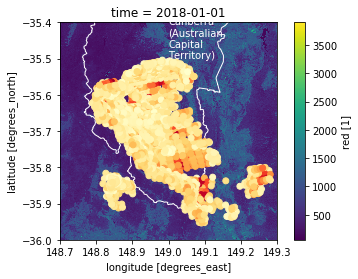

In [41]:
ds.red.plot()
gpd.read_file(act_boundary).plot(edgecolor='white', facecolor='none', ax=plt.gca())
hotspots_gdf.plot(ax=plt.gca(), column='temp_kelvin', cmap=fires_cmap)
plt.annotate(s="Canberra\n(Australian\nCapital\nTerritory)", xy=(149, -35.50), c='white')

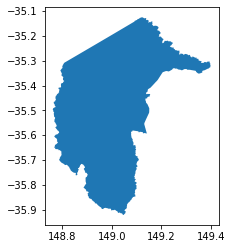

## Generate animation frames

2020-01-27 04:04:27


/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


2020-01-27 05:24:27
2020-01-27 06:44:27
2020-01-27 08:04:27
2020-01-27 09:24:27
2020-01-27 10:44:27
2020-01-27 12:04:27
2020-01-27 13:24:27
2020-01-27 14:44:27
2020-01-27 16:04:27
2020-01-27 17:24:27
2020-01-27 18:44:27
2020-01-27 20:04:27
2020-01-27 21:24:27
2020-01-27 22:44:27
2020-01-28 00:04:27
2020-01-28 01:24:27
2020-01-28 02:44:27
2020-01-28 04:04:27
2020-01-28 05:24:27
2020-01-28 06:44:27
2020-01-28 08:04:27
2020-01-28 09:24:27
2020-01-28 10:44:27
2020-01-28 12:04:27
2020-01-28 13:24:27
2020-01-28 14:44:27
2020-01-28 16:04:27
2020-01-28 17:24:27
2020-01-28 18:44:27
2020-01-28 20:04:27
2020-01-28 21:24:27
2020-01-28 22:44:27
2020-01-29 00:04:27
2020-01-29 01:24:27
2020-01-29 02:44:27
2020-01-29 04:04:27
2020-01-29 05:24:27
2020-01-29 06:44:27
2020-01-29 08:04:27
2020-01-29 09:24:27
2020-01-29 10:44:27
2020-01-29 12:04:27
2020-01-29 13:24:27
2020-01-29 14:44:27
2020-01-29 16:04:27
2020-01-29 17:24:27
2020-01-29 18:44:27
2020-01-29 20:04:27
2020-01-29 21:24:27
2020-01-29 22:44:27


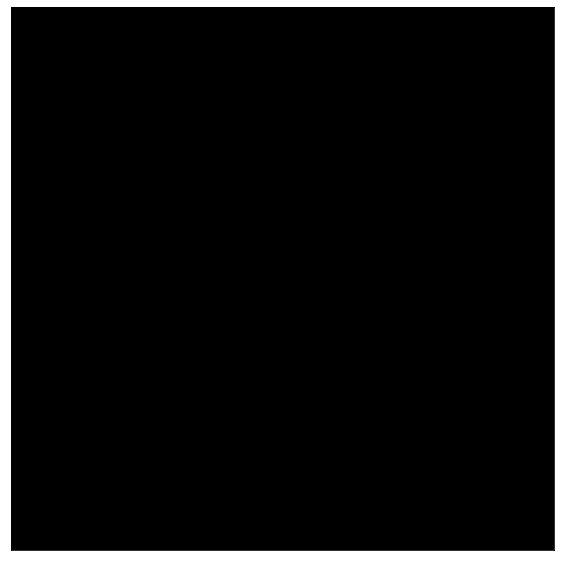

In [71]:
# If output folder doesn't exist, create it
output_dir = f'frames_{name}'
os.makedirs(output_dir, exist_ok=True)

# Get date/times to iterate through (1 per frame)
comp_dates = pd.date_range(hotspots_gdf.datetime.min(), 
                           (dt.datetime.today() + dt.timedelta(days=0.7)), 
                           freq=frame_freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, comp_date in enumerate(comp_dates):
    
    print(comp_date)

    # Extract only hotspots occuring prior to frame date/time
    hotspots_prev = hotspots_gdf.loc[
        hotspots_gdf['datetime'] < comp_date].copy()
    
    # Calculate hours between frame date and hotspot and sort
    hotspots_prev['hours_before'] = ((
        (comp_date - hotspots_prev['datetime'])).astype('timedelta64[m]') / 60)
    hotspots_prev.sort_values('hours_before', inplace=True, ascending=False)

    # Plot Geomedian as underlay
    ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=ax, 
                                                                     vmax=2500)
    
    # Plot hotspots
    hotspots_prev.plot(ax=ax,
                       column='hours_before',
                       cmap=fires_cmap,
                       markersize=hotspots_markersize,
                       alpha=hotspots_alpha,
                       vmin=0,
                       vmax=fade_hours,
#                        vmin=hotspots_prev.temp_kelvin.min(),
#                        vmax=400,
                      )
    
    gpd.read_file(act_boundary).plot(linestyle=':', edgecolor='white', facecolor='none', ax=plt.gca())
    plt.annotate(s="Canberra", 
                 xy=(149.08, -35.425), 
                 c='white',
                 va='top', ha='center', 
                 fontname='Liberation Sans', weight='bold',
                 fontsize=13), 
    plt.annotate(s="Australian\nCapital\nTerritory", 
             xy=(149.08, -35.445), 
             c='white',
             va='top', ha='center', 
             fontname='Liberation Sans',
             fontsize=13), 
    
    # Customise plot and add title
    ax.set_facecolor('black')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('');
    ax.text(0.03, 0.95,
            f"{comp_date.tz_localize(tz='UTC').tz_convert('Australia/Sydney'):%Y-%m-%d}",
            ha='left', 
            va='center', 
            transform=ax.transAxes,
           fontdict={'fontsize': 20, 
                     'color': 'white', 
                     'fontname':'Liberation Sans'})
    
    # Export frame to file
    fig.savefig(f'{output_dir}/hotspots_{i}.png', 
                bbox_inches='tight',
                dpi=100,
                pad_inches=0)
    plt.cla()


505.0

## Combine into MP4 animation using FFMPEG

In [88]:
!ffmpeg -y -r 12 -i $output_dir/hotspots_%d.png -c:v libx264 -vf crop=in_w-16:in_h-15,minterpolate=fps=24 -pix_fmt yuv420p $output_dir/hotspots_animation.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [78]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -vf crop=in_w-15:in_h-15,minterpolate=fps=11 $output_dir/hotspots_animation.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [8]:
print(datacube.__version__)

1.7+164.gbdf45994.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)